## C S 329E HW 10

# Add Your Names here 
- Dylan Lam
- DXL85

# Add Your Names here 



# Clustering with K-means and DBSCAN

## Your name here (and your partner's name if you are working in a pair)

For this week's homework we are going explore two clustering methods:

  - K-Means, and
  - DBSCAN
  
As we discussed in lecture, k-means creates clusters based on a distance measure, and DBSCAN creates clusters based on the density of the points in the vicinity of the data.  Using small example data sets, we will implement both algorithms and visualize the results.

Even though the example data is small and 2 dimensional, write your helper functions to not assume a 2-D data set.  Your plotting code can reference the `x` and `y` column names from the sample data directly. 

Note that I have added a one or two lines of code to the questions to test your implementations. 

In [95]:
# Do not import anything else
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Part 1 : K-Means

In the first half of the homework, we will implement the Algorithm 7.1 "Basic K-means", and apply that algorithm to a small data set provided with the assignment in the `data_kmeans.csv` file. We will build up some helper functions along the way, test them, and put it all together to apply to our small example data set. 

In [96]:
# loading in our toy data
df_kmeans = pd.read_csv('/Users/dylanlam/Documents/GitHub/data_science_practice_and_skills/datasets/data_kmeans.csv')

## Q1.1 - Write a function that returns `k` random rows from a data frame

To initialize the centroids, we pick `k` random points from a data frame.  Write a function `init_centroids( df_data, k )` that accepts two parameters: a data frame `df_data`, and an integer `k`, and returns the initial centroids for our k-means algorithm.  Note, we want the indices of the returned data frame to range from 0 - (k-1) so that we can use these as the centroid labels.  Use [pandas sample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) method, and pass it the value of $42$ for `random_state`. 

In [97]:
def init_centroids( df_data, k ):
    centroids = df_data.sample(n=k, random_state=42).reset_index(drop=True)
    return centroids

In [98]:
# Testing our init centroid function
df_centroids = init_centroids( df_kmeans, 7 )
df_centroids

,x,y
0,-0.633437,0.488756
1,-0.597736,0.632194
2,-0.635867,0.166613
3,-0.539351,-0.875532
4,-0.588597,0.293062
5,-0.127985,-0.136639
6,0.342579,0.211717


## Q1.2 - Write a function to assign every row in a data frame to a centroid 

Write a function, `assign_to_centroid`, that accepts two parameters: a data frame, `df_data`, that represents our data to be clustered, and the data frame, `df_centroids`, which is of length `k` and contains the current centroids for our clusters.  The functions returns a series of the same length of `df_data` that contains the index of the closest centroid in `df_centroid`.  Use Euclidean distance as your distance measure. 

For example, if a row of data contained the data point $(100,123)$ and the three centroids were in a data frame that had the following information:

  - Index 0 : (34,34)
  - Index 1 : (0,1)
  - Index 2 : (83,99)

The `assign_to_centroid` function would assign the index $2$ to that row of data. 

In [99]:
def assign_to_centroid(df_data, df_centroids):
  """
  This function assigns each data point in a DataFrame to its closest centroid.

  Args:
      df_data: A pandas DataFrame containing the data points to be assigned.
      df_centroids: A pandas DataFrame containing the current centroids.

  Returns:
      A pandas Series containing the index of the closest centroid for each data point.
  """

  closest_centroids = []
  for index, data_points in df_data.iterrows():
    # Initialize minimum distance and closest centroid index
    min_distance = float('inf')
    closest_centroid = None

    # Calculate Squared Euclidean distance to each centroid. k-means algorithms typically work with squared distances because 
      # it simplifies calculations, especially for high-dimensional data.
    for centroid_index, centroid in df_centroids.iterrows():
      distance = 0
      for i in range(len(data_points)):
        distance += (data_points.iloc[i] - centroid.iloc[i])**2

      # Update minimum distance and closest centroid if closer point found
      if distance < min_distance:
        min_distance = distance
        closest_centroid = centroid_index

    closest_centroids.append(closest_centroid)

  return pd.Series(closest_centroids, index=df_data.index)


In [100]:
# Check how many data points were assigned to each centroid
s_centroid_assignment = assign_to_centroid( df_kmeans, df_centroids )
s_centroid_assignment.value_counts()

6    126
1     94
3     71
5     58
0     53
2     26
4     22
Name: count, dtype: int64

In [101]:
s_centroid_assignment

0      3
1      3
2      3
3      3
4      3
      ..
445    1
446    1
447    1
448    1
449    0
Length: 450, dtype: int64

In [102]:
s_centroid_assignment.value_counts().sum()

450

## Q1.3 - Write a function that recomputes the centroids

Write a function `compute_centroids` that takes two parameters: the data frame, `df_data` containing the data being clustered, and a series of the same length that contains the label of the assigned centroid for every row in df_data, `s_centroid_assignment`. The function will return the a data frame containing the centroids (mean) value for each unique centroid. 

Note that the indices in the returned data frame should correspond to the unique values in `s_centroid_assignment`.  For example, if I found the mean value of df_data using the slice corresponding to `s_centroid_assigment == 2`, then the centroid should be in the returned data frame at `.iloc[2]`. 


In [103]:
def compute_centroids(df_data, s_centroid_assignment):
  """
  This function computes the new centroids based on assigned cluster labels.

  Args:
      df_data: A pandas DataFrame containing the data points.
      s_centroid_assignment: A pandas Series containing the assigned centroid label for each data point.

  Returns:
      A pandas DataFrame containing the recomputed centroids (mean) for each unique cluster.
  """

  # Group data points by their assigned centroid label
  grouped_data = df_data.groupby(s_centroid_assignment)

  # Calculate the mean of each group (centroid)
  centroids = grouped_data.mean()

  return centroids


In [104]:
# Test it out
df_new_centroids = compute_centroids( df_kmeans, s_centroid_assignment)
df_new_centroids

,x,y
0,-0.715983,0.500552
1,-0.721574,0.708343
2,-0.738268,-0.113830
3,-0.696694,-0.699028
4,-0.546913,0.321364
5,-0.102365,-0.188876
6,0.523364,0.238569


## Q1.4 - Write a function that compares two centroid data frames

The stopping criterion for k-means is when our centroids have not moved since the last iteration.  Write a function `compare_centroids` that is given 2 centroid data frames, `df_centroid_a`, and `df_centroid_b` as parameters and returns `True` or `False` indicating if the centroids at each unique index in the data frame are equal. Use the [equals](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.equals.html) method to compare equality of pandas Series objects. 

In [105]:
def compare_centroids(df_centroid_a, df_centroid_b):
  """
  This function compares two centroid DataFrames for equality.

  Args:
      df_centroid_a: A pandas DataFrame containing centroids from the previous iteration.
      df_centroid_b: A pandas DataFrame containing centroids from the current iteration.

  Returns:
      True if all centroids in both DataFrames are equal, False otherwise.
  """

  # Check if DataFrames have the same indices (centroids)
  if not df_centroid_a.index.equals(df_centroid_b.index):
    return False

  # Compare corresponding Series (centroids) at each index
  for index in df_centroid_a.index:
    if not df_centroid_a.loc[index].equals(df_centroid_b.loc[index]):
      return False

  # If all comparisons pass, all centroids are equal
  return True


In [106]:
# Test it out, should print True followed by False
print(compare_centroids( df_new_centroids, df_new_centroids ))
print(compare_centroids( df_new_centroids, df_centroids ))

True
False


## Q1.5 - Write a function that implements k-means

Write a function, `k_means`, that takes in as parameters 2 values, a data frame with values to cluster, `df_data`, and the number of clusters to form, `k`.  The function should return a series of data of the same length as `df_data` that contains the cluster assignment (an integer from 0 to (k-1)) for each row of data.  Use the helper functions defined in the prior questions. 

In [107]:
from random import seed

def k_means(df_data, k):
  """
  This function performs k-means clustering on a DataFrame.

  Args:
      df_data: A pandas DataFrame containing the data points to be clustered.
      k: The number of clusters to form.

  Returns:
      A pandas Series containing the cluster assignment (integer from 0 to k-1) for each data point.
  """

  seed(123)  # Set random seed for reproducibility

  # Initialize centroids randomly
  df_centroids = init_centroids(df_data.copy(), k)

  # Loop until centroids don't change significantly
  while True:
    # Assign data points to closest centroids
    s_centroid_assignment = assign_to_centroid(df_data.copy(), df_centroids.copy())

    # Recompute centroids based on assigned clusters
    df_centroids_new = compute_centroids(df_data.copy(), s_centroid_assignment.copy())

    # Check if centroids have converged
    if compare_centroids(df_centroids, df_centroids_new):
      break

    # Update centroids for next iteration
    df_centroids = df_centroids_new.copy()

  return s_centroid_assignment



In [108]:
# Call k_means with k = 5 to test
s_cluster_assignment = k_means( df_kmeans, 5)
s_cluster_assignment.value_counts()

0    178
3     89
2     74
4     63
1     46
Name: count, dtype: int64

## Q1.6 - Plot the results

Plot the points in the `df_kmeans` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`).  Label your axes, and give the plot a title. 

/var/folders/gp/2fjqrh9x7xxb3vsdhj8sqp240000gn/T/ipykernel_56647/2706920986.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')  # Choose a colormap for clusters
/var/folders/gp/2fjqrh9x7xxb3vsdhj8sqp240000gn/T/ipykernel_56647/2706920986.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_subset[feature_names[0]], data_subset[feature_names[1]], label=f"Cluster {cluster}", c=color)


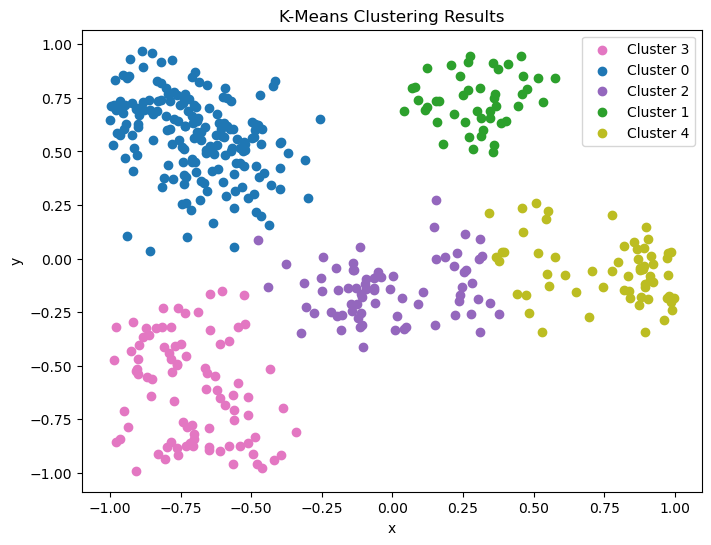

In [109]:
# Plot each cluster
def plot_clusters(df_data, s_cluster_assignment, feature_names):
  """
  This function plots the data points colored by their assigned cluster.

  Args:
      df_data: A pandas DataFrame containing the data points.
      s_cluster_assignments: A pandas Series containing the cluster assignment for each data point.
      feature_names: A list containing the names of the features used for clustering.
  """

  # Get unique cluster labels and corresponding colors
  unique_clusters = s_cluster_assignment.unique()
  cmap = plt.cm.get_cmap('tab10')  # Choose a colormap for clusters
  colors = cmap(unique_clusters / len(unique_clusters))  # Assign colors based on cluster index

  # Create scatter plot with points colored by cluster
  plt.figure(figsize=(8, 6))
  for cluster, color in zip(unique_clusters, colors):
    data_subset = df_data[s_cluster_assignment == cluster]
    plt.scatter(data_subset[feature_names[0]], data_subset[feature_names[1]], label=f"Cluster {cluster}", c=color)

  # Add labels and title
  plt.xlabel(feature_names[0])
  plt.ylabel(feature_names[1])
  plt.title("K-Means Clustering Results")
  plt.legend()
  plt.show()

# Assuming you have df_kmeans and s_cluster_assignments from previous steps
feature_names = list(df_kmeans.columns)  # Assuming the first two columns are features

plot_clusters(df_kmeans, s_cluster_assignment, feature_names)


# Part 2 : DBSCAN

## Q2.1 Load the Density Data and try K-means

Load in the data provided `data_dbscan.csv`, cluster it with k-means algorithm with $k=2$ and visualize the results with a scatter plot, where the color indicates cluster membership. Label your axes, and give the plot a title. 

/var/folders/gp/2fjqrh9x7xxb3vsdhj8sqp240000gn/T/ipykernel_56647/1067487154.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/var/folders/gp/2fjqrh9x7xxb3vsdhj8sqp240000gn/T/ipykernel_56647/1067487154.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_subset[feature_names[0]], data_subset[feature_names[1]], label=f"Cluster {cluster}", c=color)


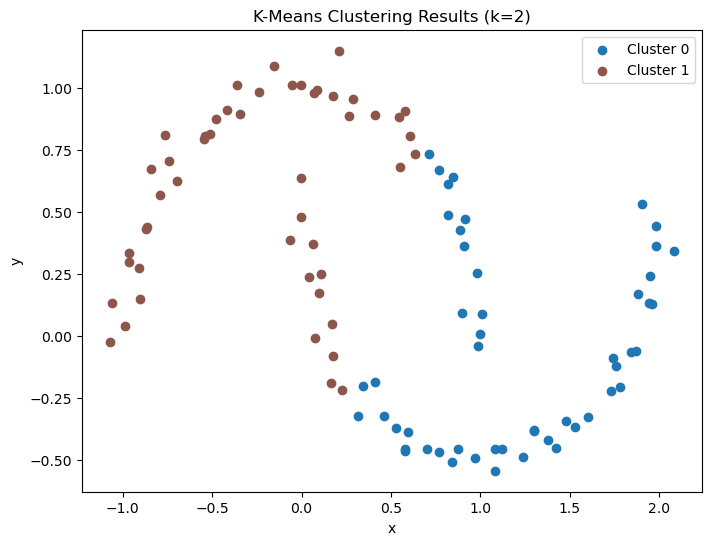

In [110]:
df_dbscan = pd.read_csv('/Users/dylanlam/Documents/GitHub/data_science_practice_and_skills/datasets/data_dbscan.csv')

# Call k_means with k = 2
s_cluster_assignment = k_means( df_dbscan, 2)

# Define a function for plotting clusters (same as previous explanation)
def plot_clusters(df_data, s_cluster_assignments, feature_names):
  unique_clusters = s_cluster_assignments.unique()
  cmap = plt.cm.get_cmap('tab10')
  colors = cmap(unique_clusters / len(unique_clusters))

  plt.figure(figsize=(8, 6))
  for cluster, color in zip(unique_clusters, colors):
    data_subset = df_data[s_cluster_assignments == cluster]
    plt.scatter(data_subset[feature_names[0]], data_subset[feature_names[1]], label=f"Cluster {cluster}", c=color)

  plt.xlabel(feature_names[0])
  plt.ylabel(feature_names[1])
  plt.title("K-Means Clustering Results (k=2)")
  plt.legend()
  plt.show()

# Plot the k-means clustering results
plot_clusters(df_dbscan.copy(), s_cluster_assignment.copy(), feature_names)

## Q2.2 Write function to Implement Range Query

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement RangeQuery.

```
RangeQuery(DB, distFunc, Q, eps) {
    Neighbors N := empty list
    for each point P in database DB {                      /* Scan all points in the database */
        if distFunc(Q, P) ≤ eps then {                     /* Compute distance and check epsilon */
            N := N ∪ {P}                                   /* Add to result */
        }
    }
    return N
}
```

The "DB" parameter is a data frame, `df_data` containing all of the points in our data set, the "distFunc" is set as Euclidean distance thus should not be passed in, the point "Q", is represented by the index of the data frame, `q_index`, where `df_data.iloc[q_index]` is the actual point, and `eps` is a floating point value that indicates the radius from the point "Q" to search for neighbors.  The function will return the slice of `df_data` of all points within `eps` distance of "Q" (including "Q").  The indices on the slice should be preserved (do not reset_index).  

In [111]:
def range_query(df_data, q_index, eps):
  """
  This function implements the RangeQuery for DBSCAN using Euclidean distance.

  Args:
      df_data: A pandas DataFrame containing all data points.
      q_index: The index of the query point in the DataFrame.
      eps: The epsilon value for the neighborhood radius.

  Returns:
      A pandas DataFrame slice containing all points within eps distance of the query point (including the query point itself).
  """
  
  # Get the query point
  query_point = df_data.iloc[q_index]

  # Calculate distances to all other points using Euclidean distance
  distances = df_data.apply(lambda row: ((row - query_point)**2).sum()**0.5, axis=1)

  # Select data points within epsilon distance of the query point
  neighbors = df_data[distances <= eps]

  return neighbors



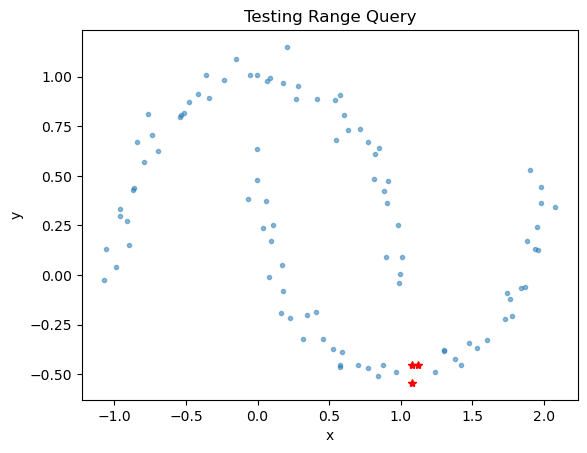

In [112]:
# Test it out
df_n = range_query( df_dbscan, 0, 0.1 )
plt.plot( df_dbscan['x'], df_dbscan['y'], '.', alpha = 0.5 )
plt.plot( df_n['x'], df_n['y'], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing Range Query')
plt.show()

## Q2.3 Write a function to implement DBSCAN

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement DBSCAN. This algorithm uses set notation, I found a handy summary on-line [here](http://www.math.cmu.edu/~bkell/21110-2010s/sets.html) if you need a refresher. 

```
DBSCAN(DB, distFunc, eps, minPts) {
    C := 0                                                  /* Cluster counter */
    for each point P in database DB {
        if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
        Neighbors N := RangeQuery(DB, distFunc, P, eps)     /* Find neighbors */
        if |N| < minPts then {                              /* Density check */
            label(P) := Noise                               /* Label as Noise */
            continue
        }
        C := C + 1                                          /* next cluster label */
        label(P) := C                                       /* Label initial point */
        SeedSet S := N \ {P}                                /* Neighbors to expand */
        for each point Q in S {                             /* Process every seed point Q */
            if label(Q) = Noise then label(Q) := C          /* Change Noise to border point */
            if label(Q) ≠ undefined then continue           /* Previously processed (e.g., border point) */
            label(Q) := C                                   /* Label neighbor */
            Neighbors N := RangeQuery(DB, distFunc, Q, eps) /* Find neighbors */
            if |N| ≥ minPts then {                          /* Density check (if Q is a core point) */
                S := S ∪ N                                  /* Add new neighbors to seed set */
            }
        }
    }
}
```

The function should accept as parameters "DB", a data frame of points to be clustered, `df_data`, no distance function (assuming Euclidean distance), a floating point `eps` that defines the radius, and an integer `minPts`.  The function will return a series of cluster assignments of the same length as `df_data`. If the data is classified as noise, the cluster assignment is $0$, and all of the clusters will have a label of $1-k$, were $k$ is derived in the function and represents the total number of clusters found. 

Don't forget that [iterrows](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) is a lovely way to loop through a data frame. But if you modify the dataframe within the loop, it doesn't add more iterations to the loop.  For example, if you start with a dataframe of length $n$ and add $3$ rows, then the `iterrows` will stop after $n$ rows. For the inside loop, you'll need to use a native python list to dynamically grow the `SeedSet S`.  You can use the `extend` function to merge 2 lists together. For example:

```
x = [1,2,3]
y = [4,5,6]
x.extend(y) # sets x to the list [1, 2, 3, 4, 5, 6]
```

If you haven't used the [continue](https://docs.python.org/3/tutorial/controlflow.html) statement before, it can be useful in these situations, check out the link. 

Call `dbscan` with the `df_dbscan` data frame, `eps` set to 0.23, and `min_pts` set to 6 and save the results to `s_cluster_assignments` 

In [113]:
def dbscan(df_data, eps, min_pts):
  """
  This function implements the DBSCAN clustering algorithm.

  Args:
      df_data: A pandas DataFrame containing all data points.
      eps: The epsilon value for the neighborhood radius.
      min_Pts: The minimum number of points required for a core point.

  Returns:
      A pandas Series containing the cluster assignments for each data point.
  """

  # Initialize cluster counter and create empty label Series
  C = 0
  cluster_labels = pd.Series([-1] * len(df_data), index=df_data.index)  # Initialize with -1 (unprocessed)

  for i, row in df_data.iterrows():
    # Skip points already processed in inner loop
    if cluster_labels.loc[i] != -1:
      continue

    # Find neighbors within epsilon distance
    neighbors = range_query(df_data.copy(), i, eps)  # Assuming you have a range_query function

    # Density check: mark as noise if neighbors < minPts
    if len(neighbors) < min_pts:
      cluster_labels.loc[i] = 0  # Noise (cluster 0)
      continue

    # New cluster: assign cluster label and create seed set
    C += 1
    cluster_labels.loc[i] = C
    seed_set = list(neighbors.index)  # Convert neighbors DataFrame to list (dynamically grows)

    # Process each seed point in the seed set
    while seed_set:
      q_index = seed_set.pop(0)

      # Update label for noise points or unprocessed points
      if cluster_labels.loc[q_index] == 0 or cluster_labels.loc[q_index] == -1:
        cluster_labels.loc[q_index] = C

      # Skip processed points
      if cluster_labels.loc[q_index] != -1:
        continue

      # Find neighbors of the seed point
      q_neighbors = range_query(df_data.copy(), q_index, eps)  # Assuming you have a range_query function

      # Density check for core points: expand seed set if neighbors >= minPts
      if len(q_neighbors) >= min_pts:
        seed_set.extend(list(q_neighbors.index))

  return cluster_labels

# Example usage (assuming you have df_dbscan defined)
s_cluster_assignments = dbscan(df_dbscan.copy(), eps=0.23, min_pts=6)



In [114]:
# Test it out
s_cluster_assignment = dbscan( df_dbscan, 0.23, 6)
s_cluster_assignment.value_counts()

3     7
9     7
1     6
5     6
18    6
10    6
2     6
16    6
17    5
7     5
15    5
14    4
19    4
8     4
11    4
0     4
6     4
4     4
13    3
12    3
20    1
Name: count, dtype: int64

## Q2.4 Plot the Results 

Plot the points in the `df_dbscan` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`). Label your axes, and give the plot a title.

/var/folders/gp/2fjqrh9x7xxb3vsdhj8sqp240000gn/T/ipykernel_56647/1067487154.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')
/var/folders/gp/2fjqrh9x7xxb3vsdhj8sqp240000gn/T/ipykernel_56647/1067487154.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_subset[feature_names[0]], data_subset[feature_names[1]], label=f"Cluster {cluster}", c=color)


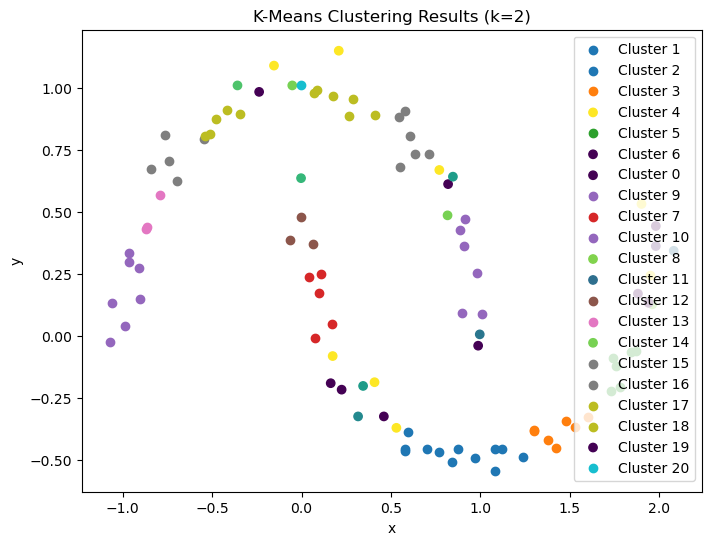

In [115]:
# Plot each cluster

# Plot the k-means clustering results (using the same function)
plot_clusters(df_dbscan.copy(), s_cluster_assignments.copy(), feature_names)


## Q2.5 Compare your results to the scikit-learn library

Import DBSCAN from scikit-learn and compare the cluster labels from your implementation to the cluster labels generated from [scikit-learn's DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Add some commentary about how you think the results compare. Use the same data and values for eps and minPts.

   Custom Label  scikit-learn Label
0             1                   0
1             2                   0
2             1                   0
3             1                   0
4             2                   0
Adjusted Rand Index (ARI): 0.0940


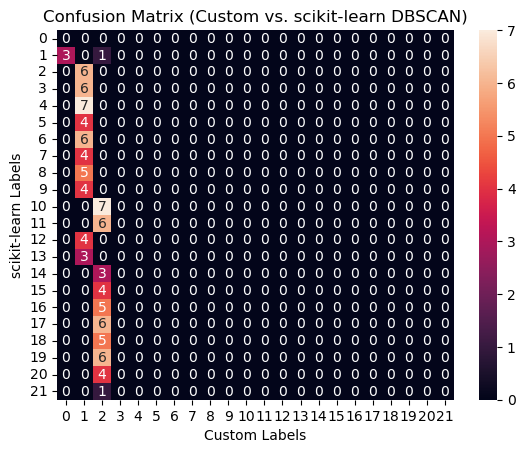

In [116]:
# check your implementation vs scikit-learn
from sklearn.cluster import DBSCAN

# Assuming you have df_dbscan, eps (set to 0.23), and min_pts (set to 6) from previous steps

# Cluster labels from your implementation
custom_labels = dbscan(df_dbscan.copy(), .23, 6)

# Cluster labels from scikit-learn's DBSCAN
sklearn_dbscan = DBSCAN(eps=.23, min_samples=6)  # min_samples is equivalent to minPts
sklearn_labels = sklearn_dbscan.fit_predict(df_dbscan.copy())

# Compare the results (assuming custom_labels and sklearn_labels have the same index)
comparison = pd.DataFrame({'Custom Label': custom_labels, 'scikit-learn Label': sklearn_labels})
print(comparison.head())  # Print the first few rows for comparison

# Calculate the adjusted Rand index (ARI) for a more quantitative comparison
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(custom_labels, sklearn_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Optional: Visual comparison using confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(custom_labels, sklearn_labels)
ax = sns.heatmap(cm, annot=True)
ax.set_xlabel('Custom Labels')
ax.set_ylabel('scikit-learn Labels')
ax.set_title('Confusion Matrix (Custom vs. scikit-learn DBSCAN)')
plt.show()


your obervations about scikit-learn's performance vs your implementation's performance here